#### Hello! This notebook is inspired by this article on Twitter sentiment analysis using VADER: https://www.ijariit.com/manuscripts/v4i1/V4I1-1307.pdf. 

#### The authors, big fans of Harry Potter decided to analyse tweets of J. K. Rowling and do the following things.

- Use different approaches for the sentiment analysis: SVM, Neural Network & VADER
- Do a sentiment analysis on J.K. Rowling tweets
- Do a sentiment analysis on tweets about Harry Potter
- Compare the difference
- Visualise the magic

In [2]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/zeeYz6iGGoaA0/giphy.gif">')

For the steps we did, you will need the following things installed and imported

### Let's download some stuff

In [3]:
import sys
!{sys.executable} -m pip install vaderSentiment


In [40]:
!{sys.executable} -m pip install pywsd

### Let's import some stuff

In [5]:
import pandas as pd
import numpy as np
import nltk
import re
import spacy
import gensim
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pywsd.utils import lemmatize, lemmatize_sentence
from wordcloud import WordCloud

from dateutil import parser
from datetime import date


Warming up PyWSD (takes ~10 secs)... took 6.229773044586182 secs.


In [6]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mhirna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/mhirna/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mhirna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Now, we will need our main dataset.
This dataset can be found here https://github.com/alexwlchan/jkr-tweetr. It has 4451 tweets.

### Let's create a dataframe

In [7]:
data = pd.read_json("jkr.json").T.reset_index().drop(columns=["index", "url"])
data["date"] = [parser.parse(date) for date in data.date]
data["date"] = [date(dt.year, dt.month, dt.day) for dt in data.date]

In [8]:
data.head()

,date,is_about_hp,text
0,2016-07-11,False,@PhelpsieSarah She literally tried to hook my ...
1,2016-07-11,False,@nickeardleybbc As it's hot enough to leave th...
2,2016-07-11,NaN,"""If you're going to write while we're on holid..."
3,2016-07-10,NaN,When you meet an old friend in an unexpected p...
4,2016-07-03,False,"RT @KateMaltby: And on Geoffrey Hill's death, ..."


We can see, that we have three columns:
- date - date of the tweet
- is_about_hp - if tweet was about Harry Potter or not
- text - actual text of the tweet

### Let's clean a dataset

Now we will need to clean the data of tweets. As, of course, they are full of mentioning other users, hashtags, slang and other language hard to undestand for algorithms

In [9]:
x = data.text

Firstly, remove @usernames and links

In [10]:
# Remove links
x = [re.sub(r'http\S+', '', tweet, flags=re.MULTILINE) for tweet in x]

# Remove @usernames
x = [re.sub('@[^\s]+', '', tweet, flags=re.MULTILINE) for tweet in x]

# Remove #hashtags
x = [re.sub('#', '', tweet, flags=re.MULTILINE) for tweet in x]

In [11]:
x[0]

' She literally tried to hook my hand away from the keyboard before sticking her tongue in my ear.'

Secondly, let's remove stopwords. Stopwords are words that don't tell significant information about the text - things like you, me, do, will, any

In [12]:
# NLTK Stop word
stop_words = stopwords.words('english')

# Also remove Re-tweet
stop_words.extend(['rt'])

def remove_stopwords(texts):
    return [" ".join([word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words]) for doc in texts]

x = remove_stopwords(x)

In [13]:
x[0]

'literally tried hook hand away keyboard sticking tongue ear'

Thridly, let's lemmitize our words. Lemmatization is the process of bringing words to their original form. For example
- did -> do
- wands -> wand
- better -> good

In [14]:
x = [" ".join(lemmatize_sentence(tweet)) for tweet in x]

In [15]:
x[:5]

['literally try hook hand away keyboard stick tongue ear',
 'hot enough leave door open constantly ask go find another trick',
 'go write holiday go lick suntan lotion ear',
 'meet old friend unexpected place',
 'geoffrey hill death friend recall poet defence difficulty need heavy dose today']

Now, we will add this preprocessed text to the dataframe.

In [16]:
data["preprocessed_text"] = x

In [17]:
data.head()

,date,is_about_hp,text,preprocessed_text
0,2016-07-11,False,@PhelpsieSarah She literally tried to hook my ...,literally try hook hand away keyboard stick to...
1,2016-07-11,False,@nickeardleybbc As it's hot enough to leave th...,hot enough leave door open constantly ask go f...
2,2016-07-11,NaN,"""If you're going to write while we're on holid...",go write holiday go lick suntan lotion ear
3,2016-07-10,NaN,When you meet an old friend in an unexpected p...,meet old friend unexpected place
4,2016-07-03,False,"RT @KateMaltby: And on Geoffrey Hill's death, ...",geoffrey hill death friend recall poet defence...


## Model training

Now, we will try two very popular algorithms for sentiment analysis - SVM and VADER. Due to https://www.diva-portal.org/smash/get/diva2:930520/FULLTEXT01.pdf they have the following accuracy:

 - SVM - 59.5%
 - VADER - 72.3%

In [18]:
HTML('<img src="https://media.giphy.com/media/MtCmpv4pJxRx6/giphy.gif">')

Although, we can not check accuracy in our situation, we can still compare the results. However, we will mostly use VADER, as from practice it's more accurate.

### SVM

For the support vector machine we will first need to import some data to train the model on. We found pretty close Twitter data, so we hope it will work well on our data.

Step one. Clean data the same way we did for out harry potter data

In [19]:
data_tr = pd.read_csv("train.csv",encoding = "latin1")
data_tr.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [20]:
x1 = data_tr["tweet"]

# Clean tweets
x1 = [re.sub(r'http\S+', '', tweet, flags=re.MULTILINE) for tweet in x1]
x1 = [re.sub('@[^\s]+', '', tweet, flags=re.MULTILINE) for tweet in x1]
x1 = [re.sub('#(\w+)', '', tweet, flags=re.MULTILINE) for tweet in x1]
x1 = remove_stopwords(x1)

data_tr["preprocessed_text"] = x1
text_vectorized =[]

# Create bag of words matrix
all_words = set(list(data_tr["preprocessed_text"]) + list(data.preprocessed_text))
BoW_Vector = CountVectorizer(min_df = 0., max_df = 1.).fit(list(all_words))
text_vectorized = BoW_Vector.transform(data_tr["preprocessed_text"] )
text_rowling_vectorized = BoW_Vector.transform(data.preprocessed_text)    

Step two. Separate train and test data

In [21]:
y = np.array(data_tr["label"])
x_train, x_test, y_train, y_test = train_test_split(text_vectorized, y,test_size=0.33, random_state=42)

# See the positive / negative balance
num_neg = len(y_train[y_train==1]) 
num_pos = len(y_train) - num_neg

# Train a model
svm_classifier = LinearSVC().fit(x_train, y_train)

# Predict the results
svm_train_predicted = svm_classifier.predict(x_train)
svm_test_predicted = svm_classifier.predict(x_test)

# Calculate the accuracy
svm_train_acc = accuracy_score(svm_train_predicted, y_train)
svm_test_acc = accuracy_score(svm_test_predicted, y_test)

print('Train acuracy : ',svm_train_acc)
print('Test acuracy : ',svm_test_acc)

Train acuracy :  0.9942560941440179
Test acuracy :  0.9465301478953356


That's pretty good accuracy, so we will use this model to predict emotions for JK tweets

Now, because we want not the class, but the probability (the level of positive and negative), we will use sklearn CalibratedClassifierCV

In [22]:
clf = CalibratedClassifierCV(svm_classifier, cv=3) 
clf.fit(x_train, y_train)
y_proba = clf.predict_proba(text_rowling_vectorized)

probability = []
for i in y_proba:
    if i[0] > i[1]:
        probability.append(i[0])
    else:
        probability.append(1 - i[1])

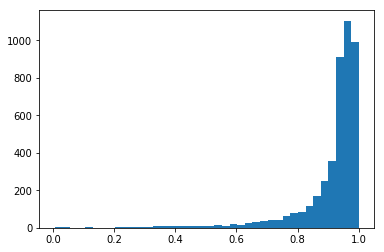

In [23]:
dist = plt.hist(probability, bins=40)

We can see, that JK Rowlings posts are mainly positive. 

### VADER

#### Now, let's see how way more better algorithm predicts emotions of JK posts

In [24]:
HTML('<img src="https://media.giphy.com/media/l1KuhBCqxOoJyr0m4/giphy.gif">')

In [25]:
analyzer = SentimentIntensityAnalyzer()
scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in list(x)]

/home/mhirna/miniconda3/envs/AI_course/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


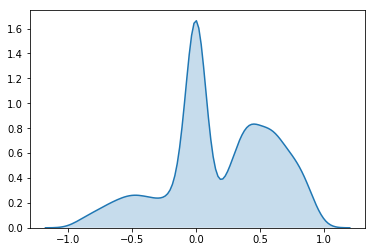

In [26]:
import seaborn as sns

# plot of 2 variables
p1=sns.kdeplot(scores, shade=True)

We can see, that most posts are considered neutral, the rest - mostly positive.

In [27]:
data["score_vader"] = scores
vader_class = []
for score in scores:
    if -0.001 < score < 0.001 :
        vader_class.append("neutral")
    elif score < 0:
        vader_class.append("negative")
    else:
        vader_class.append("positive")
data["vader_class"] = vader_class       

In [28]:
data.head()

,date,is_about_hp,text,preprocessed_text,score_vader,vader_class
0,2016-07-11,False,@PhelpsieSarah She literally tried to hook my ...,literally try hook hand away keyboard stick to...,0.4939,positive
1,2016-07-11,False,@nickeardleybbc As it's hot enough to leave th...,hot enough leave door open constantly ask go f...,-0.1027,negative
2,2016-07-11,NaN,"""If you're going to write while we're on holid...",go write holiday go lick suntan lotion ear,0.4019,positive
3,2016-07-10,NaN,When you meet an old friend in an unexpected p...,meet old friend unexpected place,0.4939,positive
4,2016-07-03,False,"RT @KateMaltby: And on Geoffrey Hill's death, ...",geoffrey hill death friend recall poet defence...,-0.4019,negative


In [29]:
pd.DataFrame.to_csv(data, "tweeter_rowling.csv")

## Let's do some visualization, shall we?

Firstly, let's compare kernel density estimation for tweets about Harry Potter and not Harry Potter

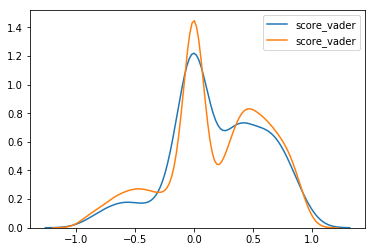

In [30]:
import seaborn as sns

# plot of 2 variables
p1=sns.kdeplot(data[data.is_about_hp == True].score_vader)
p1=sns.kdeplot(data[data.is_about_hp == False].score_vader)

In [32]:
HTML('<img src="https://raw.githubusercontent.com/mhirna/hp_tweets_sentiment_analysis/master/tweets_ts.jpeg">')

In [33]:
dt = pd.read_csv("tweeter_rowling.csv").drop(columns=["Unnamed: 0"])

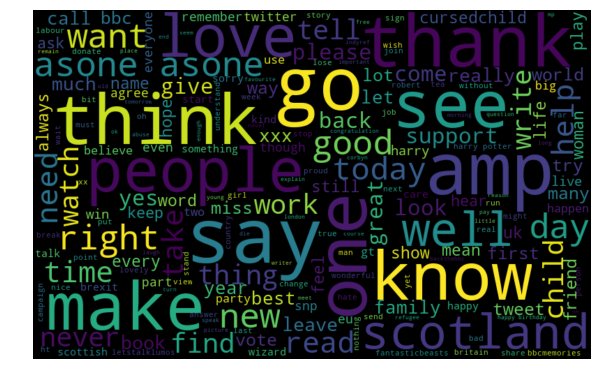

In [34]:
# Rowling's words
all_r_words = ' '.join([text for text in data["preprocessed_text"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_r_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

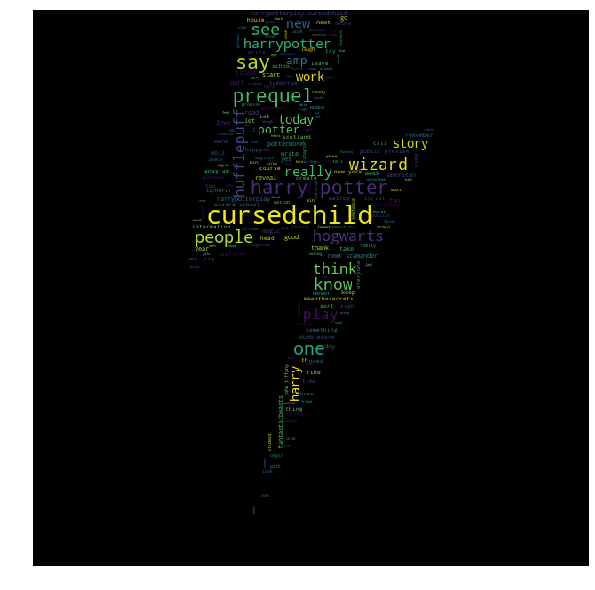

In [39]:
# Rowling's words about Harry Potter
from PIL import Image
mask = np.array(Image.open("harry10.jpg"))


def generate_wordcloud(words, mask):
    # thanks blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e
    word_cloud = WordCloud(width = 800, height = 800, background_color='black',  mask=mask, ).generate(words)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

data_hp = data[data["is_about_hp"] == True]
# data_hp
all_r_hp_words = ' '.join([text for text in data_hp["preprocessed_text"]])

generate_wordcloud(all_r_hp_words, mask)

That's it! We hope you could see how different are wordclouds and distributions of emotions for different types of tweets. And also, we hope, that you've learned something!

In [41]:
HTML('<img src="https://i.pinimg.com/originals/15/1d/56/151d56d0b4fe075dc9d2afc140039562.gif"/>')

Byye